# Deep Q-Network for Cart-Pole.

In this assignment you are required to implement a Deep Q-Network agent, for the Cart-Pole problem.

You need to submit your code, along with a plot of the rewards during training, and a video of an episode with the trained agent.


__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for PyTorch, but you'll find it easy to adapt it to almost any Python-based deep learning framework.

In [1]:
!pip install stable-baselines3 gym==0.22.0
!pip install pyglet==1.5.27
!pip install pyvirtualdisplay

In [2]:
from collections import deque
import os
import random
import numpy as np
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !apt-get -qq install -y xvfb
    os.environ['DISPLAY'] = ':1'

display = Display(visible=0, size=(400, 300))
display.start()


## Cart Pole

In this environment a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

The observation consists of the cart position, cart velocity, pole angle and pole angular velocity.

There are 2 actions corresponding to moving the cart to the left and to the right.

See full description [here](https://www.gymlibrary.dev/environments/classic_control/cart_pole/).



In [3]:
ENV_NAME = "CartPole-v0"

def make_env(seed=None):
    # some envs are wrapped with a time limit wrapper by default
    env = gym.make(ENV_NAME).unwrapped
    if seed is not None:
        env.seed(seed)
    return env

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


observation dim (4,) number of actions 2


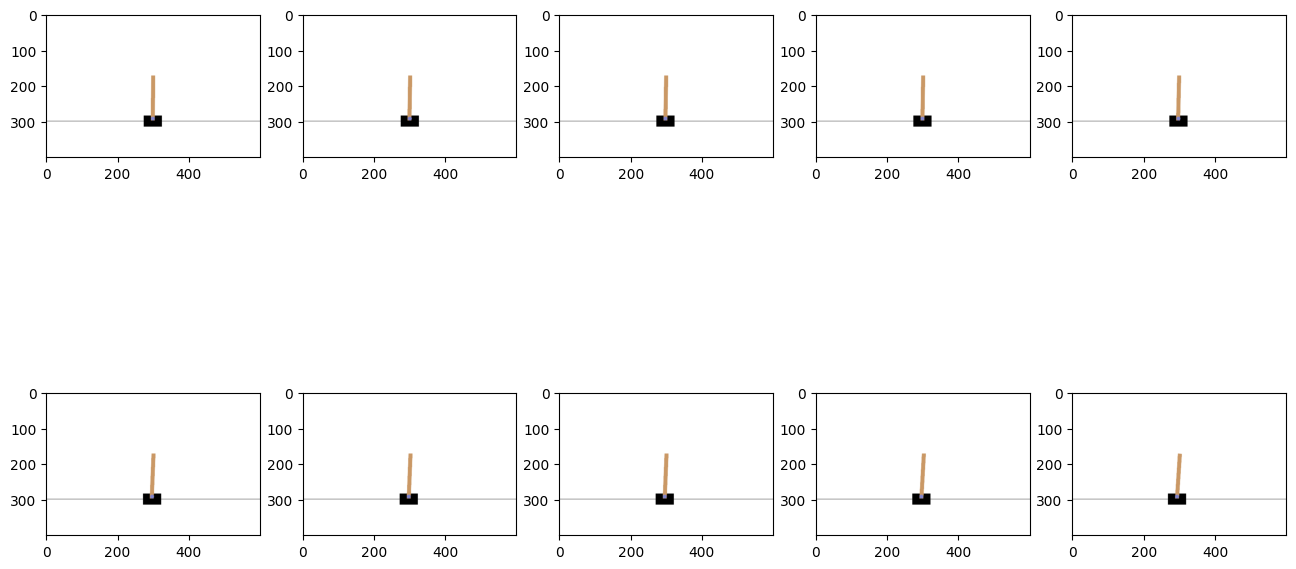

In [4]:
env = gym.make(ENV_NAME)
obs = env.reset()


n_actions = env.action_space.n
obs_dim = obs.shape
print("observation dim", obs_dim, "number of actions", n_actions)

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render('rgb_array'))
        env.step(env.action_space.sample())
plt.show()

## Random Agent

Here we implement a random agent to use in the 'evaluate' function, that runs the agent through multiple epsiodes.

In [5]:
class RandomAgent():
    def __init__(self, n_actions):
        self.n_actions = n_actions


    def get_qvalues(self, states):
        return np.random.normal(size=(1,self.n_actions,))

    def sample_actions(self, qvalues):
        return np.random.randint(self.n_actions, size=(1,))

In [6]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
              break

        rewards.append(reward)
    return np.mean(rewards)

agent = RandomAgent(n_actions)
mean_reward = evaluate(env, agent, greedy=True, n_games=5)

## Assignment

Implement a DQN agent that contains:
1. A neural network that predicts the q-values for a given observation.
2. An experience replay buffer where all transitions are added.
3. A target Q-network that is formed by periodically copying the weights of the main Q-nework.

You will also need to implement the training loop, and submit a figure showing the reward as a function of the training step, and a video showing an episode with the trained agent.

## Q-Network

In [7]:
# Define the Q-network
class QNetwork(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(QNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        self.fc3 = torch.nn.Linear(256, 64)
        self.fc4 = torch.nn.Linear(64, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

## DQN Agent

In [9]:
# Define the DQN Agent

class DQNAgent:
    def __init__(self, input_size, hidden_size, output_size, lr, discount_factor, epsilon, epsilon_decay):
        self.q_network = QNetwork(input_size, hidden_size, output_size)
        self.target_network = QNetwork(input_size, hidden_size, output_size)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = torch.optim.RMSprop(self.q_network.parameters(), lr=lr, alpha=0.9, eps=0.01)
        self.criterion = torch.nn.MSELoss()
        self.discount_factor = discount_factor
        self.input_size = input_size
        self.output_size = output_size
        self.epsilon = epsilon
        self.epsilon_min = 0.001
        self.epsilon_decay = epsilon_decay
        self.replay_buffer = deque(maxlen=2000)
        self.steps_offline = 64

    def select_action(self, state):
      # Selecting action according to epsilon-greedy policy
        if np.random.rand() < self.epsilon:
            return random.randrange(self.output_size)
        else:
          state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
          with torch.no_grad():
            q_values = self.q_network(state)
          return torch.argmax(q_values).item()

    def update_q_network(self, state, action, reward, next_state, done):
        # update q newtwork (step function)

        # Adding the observation to replay buffer
        self.replay_buffer.append((state, action, reward, next_state, done))

        # Getting the offline batch and updating the q network
        offline_batch = self.steps_offline
        if len(self.replay_buffer) < self.steps_offline:
          return

        sampled_observations = random.sample(self.replay_buffer, offline_batch)
        state, action, reward, next_state, done = zip(*sampled_observations)

        state = torch.tensor(state, dtype=torch.float32)
        action = torch.tensor(action, dtype=torch.int64).unsqueeze(1)
        reward = torch.tensor(reward, dtype=torch.float32)
        next_state = torch.tensor(next_state, dtype=torch.float32)
        done = torch.tensor(done,  dtype=torch.int64)


        # Calculate Q-value
        q_values = self.q_network(state)
        q_value = q_values.gather(1, action)

        # Calculate target Q-value
        with torch.no_grad():
            max_next_q_value = self.target_network(next_state).max(1)[0].detach()
            target_q_value = reward + self.discount_factor * max_next_q_value * (1 - done)

        # Update Q-network
        loss = 0.5 * self.criterion(q_value, target_q_value.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        # Updating the target network by copying the q network parameters to it
        self.target_network.load_state_dict(self.q_network.state_dict())

    def get_qvalues(self, state):
        # Getting the Q values as tensor form the Q Network
        with torch.no_grad():
          state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
          q_values = self.q_network(state)
        return q_values.squeeze().cpu().numpy()

    def sample_actions(self, q_values):
        # Sample actions for evaluating the agent, we do not need the epsilon
        with torch.no_grad():
            q_values = torch.tensor(q_values, dtype=torch.float32)
            action = q_values.argmax().item()  # Get the index of the maximum Q-value
            return [action]

    def decay_epsilon(self):
        # Decaying the epsilon, while maintaining at leas a value=0.001 for epsilon
        self.epsilon = max([self.epsilon * self.epsilon_decay, 0.001])

    def state_dict(self):
      # Saving DQN Agent Networks parmeters
      torch.save(self.q_network.state_dict(), '/content/drive/My Drive/Colab/dqn_CartPole_QNetwork_model.pth')
      torch.save(self.target_network.state_dict(), '/content/drive/My Drive/Colab/dqn_CartPole_target_model.pth')

    def state_load(self):
      # Loading DQN Agent Networks parmeters
      self.q_network.load_state_dict(torch.load('/content/drive/My Drive/Colab/dqn_CartPole_QNetwork_model.pth'))
      self.target_network.load_state_dict(torch.load('/content/drive/My Drive/Colab/dqn_CartPole_target_model.pth'))



## Training

In [10]:
from google.colab import drive
drive.mount('/content/drive')

# Hyperparameters
lr = 0.00025
discount_factor = 0.99
hidden_size = 32
batch_size = 64
num_episodes = 150
epsilon = 1
decay_epsilon = 0.9

input_size = env.observation_space.shape[0]
output_size = env.action_space.n

# Initialize the agent
agent = DQNAgent(input_size, hidden_size, output_size, lr, discount_factor, epsilon, decay_epsilon)

rewards =[]
cons = 0
cnt = 0

# Training loop
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update_q_network(state, action, reward, next_state, done)
        total_reward += reward
        state = next_state

        # Updating the target network every 50 step
        cnt += 1
        if cnt % 50 == 0:
          cnt = 0
          agent.update_target_network()

    # saving the rewards for each epsoide
    rewards.append(total_reward)

    # Decaying Epsilon
    agent.decay_epsilon()

    # Saving the model
    agent.state_dict()

    print(f"Episode: {episode + 1}, Total Reward: {total_reward}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Episode: 1, Total Reward: 62.0
Episode: 2, Total Reward: 17.0


<ipython-input-9-d526c3e00572>:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  state = torch.tensor(state, dtype=torch.float32)


Episode: 3, Total Reward: 11.0
Episode: 4, Total Reward: 13.0
Episode: 5, Total Reward: 8.0
Episode: 6, Total Reward: 12.0
Episode: 7, Total Reward: 10.0
Episode: 8, Total Reward: 17.0
Episode: 9, Total Reward: 13.0
Episode: 10, Total Reward: 12.0
Episode: 11, Total Reward: 14.0
Episode: 12, Total Reward: 10.0
Episode: 13, Total Reward: 10.0
Episode: 14, Total Reward: 10.0
Episode: 15, Total Reward: 10.0
Episode: 16, Total Reward: 11.0
Episode: 17, Total Reward: 15.0
Episode: 18, Total Reward: 10.0
Episode: 19, Total Reward: 9.0
Episode: 20, Total Reward: 10.0
Episode: 21, Total Reward: 9.0
Episode: 22, Total Reward: 13.0
Episode: 23, Total Reward: 11.0
Episode: 24, Total Reward: 13.0
Episode: 25, Total Reward: 28.0
Episode: 26, Total Reward: 10.0
Episode: 27, Total Reward: 11.0
Episode: 28, Total Reward: 21.0
Episode: 29, Total Reward: 9.0
Episode: 30, Total Reward: 25.0
Episode: 31, Total Reward: 12.0
Episode: 32, Total Reward: 8.0
Episode: 33, Total Reward: 13.0
Episode: 34, Total R

## Test REWARD PLOTS

Plotting the total rewards for each epsoide during the test

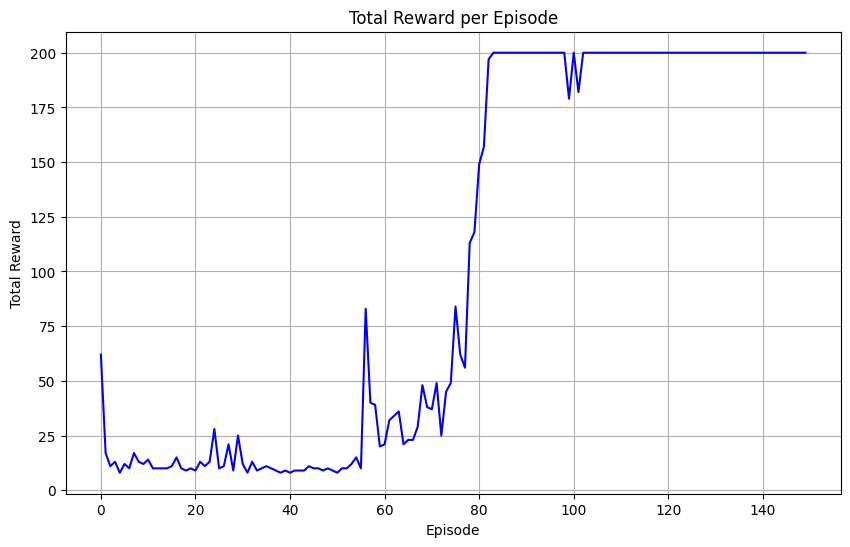

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(rewards, color='blue')
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

## Test Rewards Plots

Evaluating the agent, by plotting the mean rewards of 10 games 10 times

**We can see we always get a reward 200 which is the maximum reward

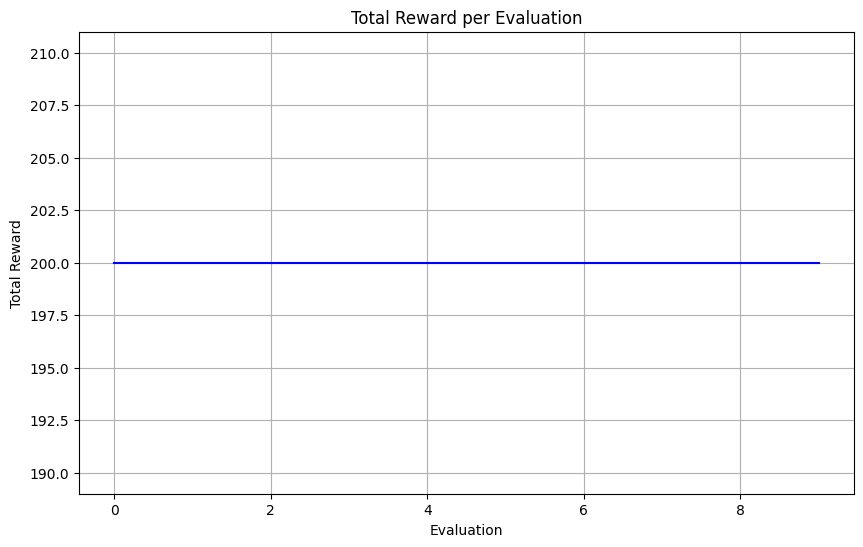

In [12]:
import matplotlib.pyplot as plt

# Initialize the agent
agent = DQNAgent(input_size, hidden_size, output_size, lr, discount_factor, epsilon, decay_epsilon)

# Loading the agent parameters
agent.state_load()

# Getting test rewards
test_rewards = [evaluate(env, agent, greedy=False, n_games=10) for i in range (10)]

plt.figure(figsize=(10, 6))
plt.plot(test_rewards, color='blue')
plt.title('Total Reward per Evaluation')
plt.xlabel('Evaluation')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

## Video generation

In [14]:
# run sessions

import gym.wrappers
import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML


# Hyperparameters
lr = 0.00025
discount_factor = 0.95
hidden_size = 32
batch_size = 64
num_episodes = 2000
epsilon = 1
decay_epsilon = 0.9

input_size = env.observation_space.shape[0]
output_size = env.action_space.n

# Initialize the agent
agent = DQNAgent(input_size, hidden_size, output_size, lr, discount_factor, epsilon, decay_epsilon)

# Loading the agent parameters
agent.state_load()

# how many games to record
n_games = 1

# Evaluating the agent

with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    env_monitor.reset()
    sessions = [evaluate(env_monitor, agent, n_games, greedy=False) for _ in range(n_games)]

# show video
video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices (if n_games>1)

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(
